# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [1]:
import numpy as np 

H = np.load('Hamiltonian_Example.npy')

In [2]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-3.34084762e+00, -3.29295138e+00, -2.86387634e+00, -2.78526086e+00,
       -1.56155281e+00, -1.56155281e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -5.61552813e-01, -5.61552813e-01,
       -6.27731229e-16,  5.07690516e-01,  5.23028722e-01,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.47697128e+00,  1.49230948e+00,  2.00000000e+00,
        2.56155281e+00,  2.56155281e+00,  3.00000000e+00,  3.00000000e+00,
        3.00000000e+00,  3.00000000e+00,  3.56155281e+00,  3.56155281e+00,
        4.78526086e+00,  4.86387634e+00,  5.29295138e+00,  5.34084762e+00])

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [3]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [4]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [5]:
import pandas as pd

pd.DataFrame(blocks['3,3'].to_matrix())

,0,1,2,3,4,5,6,7
0,1.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,-1.0+0.0j,1.0+0.0j,-1.0+0.0j,-1.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,-1.0+0.0j,0.0+0.0j,2.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,1.0+0.0j,0.0+0.0j,-1.0+0.0j,-1.0+0.0j,1.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j,0.0+0.0j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,10.0+0.0j


In [6]:
print(blocks['0,0'])

SummedOp([
  3.25 * III,
  -0.5 * IIX,
  0.25 * IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -2.25 * IZI,
  -0.5 * IZX,
  0.25 * IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -2.0 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [7]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-7-4f4400865c4e>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-7-4f4400865c4e>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [8]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)
pd.DataFrame(H_complete)

,0,1,2,3,4,5,6,...,41,42,43,44,45,46,47
0,2,-1,0,0,1,0,0,...,0,0,0,0,0,0,0
1,-1,1,-1,-1,0,1,0,...,0,0,0,0,0,0,0
2,0,-1,1,0,-1,0,0,...,0,0,0,0,0,0,0
3,0,-1,0,1,-1,0,0,...,0,0,0,0,0,0,0
4,1,0,-1,-1,1,-1,0,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0,0,0,0,0,0,0,...,-1,0,1,-1,0,0,0
44,0,0,0,0,0,0,0,...,0,-1,-1,1,-1,0,0
45,0,0,0,0,0,0,0,...,1,0,0,-1,2,0,0
46,0,0,0,0,0,0,0,...,0,0,0,0,0,10,0


In [9]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

-3.3408476172483557
-3.3408476172483548


## The Anzatz circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [10]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))


In [11]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i


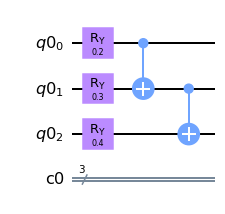

In [12]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [13]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir


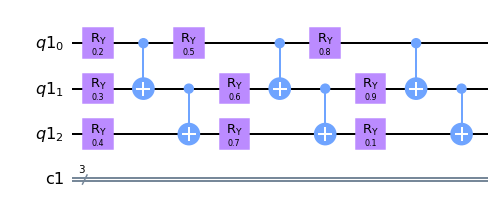

In [14]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

In order to deal with off diagonal blocks, we will also need to form $$ U^{ab} = I\otimes U^a + X \otimes U^b$$

In order to create this gate we need a controled-Ry gate.  The controled-Ry can be built as $C_{R_y}(\phi) = R_y(\phi/2)C_{NOT}R_y(-\phi/2)C_{NOT}$

In [15]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

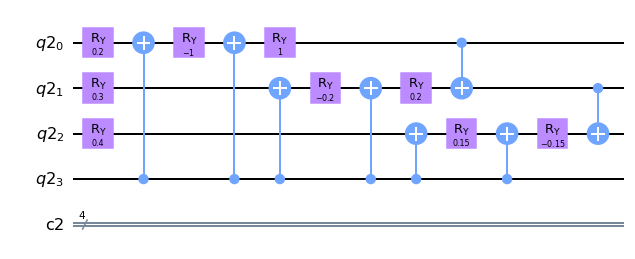

In [16]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

Let's check to make sure we are generating the right thing

In [17]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j]
B:
[0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]
AB:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j
 0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]


In [18]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

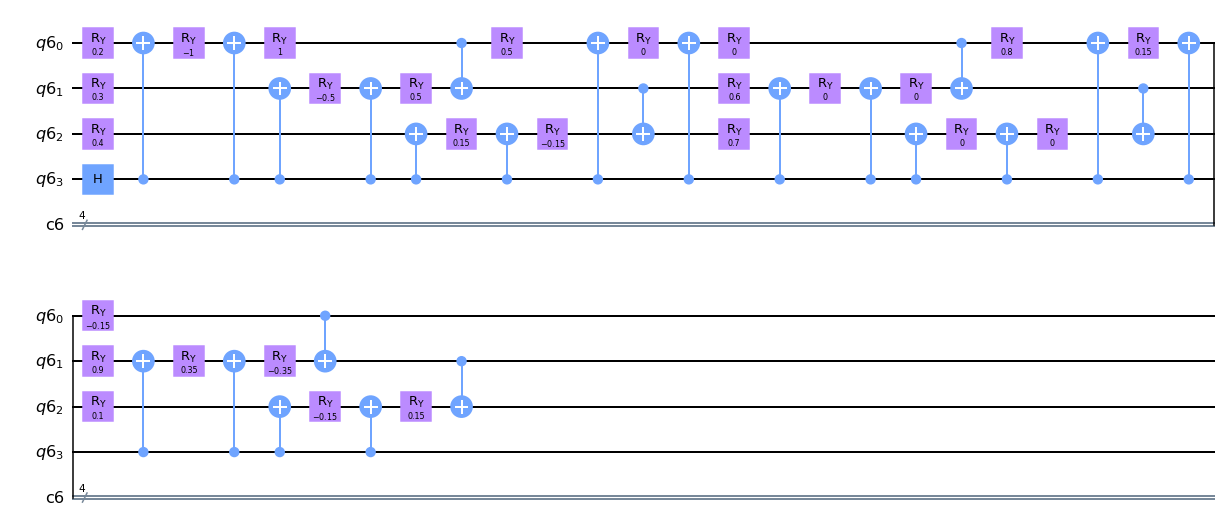

In [19]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  


To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



In [20]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def measure_pauli(p_label,psi0,method = 'simple'):
    
    #Simple method of calculation####
    if method == 'simple':
        wave0 = qi.Statevector.from_instruction(psi0)
        Op = qi.Operator.from_label(p_label)
        return np.dot(np.conjugate(wave0),np.dot(Op,wave0))
    #################################
        
    #apply rotations#################
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'
    ################################
    
    #Using matrix multiplication####
    if method == 'matrix':
        # add results
        wave = qi.Statevector.from_instruction(psi)
        r = wave.probabilities_dict()
        z_measure = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
        return z_measure
    #################################
    
    #Using the qasm simulator########
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        psi.measure(psi.qubits,psi.clbits)
        r = execute(psi, backend = sim).result().get_counts()
        z_measure = 0
        total = 0
        for key in list(r.keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and pauli_qs[q] == 1:
                    n += 1
            z_measure += (-1)**n * r[key] 
            total += r[key]
        return z_measure/total
    ###################################
    
    raise NameError(method + ' is not a recognized method')
    return method + ' is not a recognized method'
  

#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][17].primitive.to_label()
        
    
print( measure_pauli(p_label,psi0,method = 'simple') )
print( measure_pauli(p_label,psi0,method = 'matrix') )
print( measure_pauli(p_label,psi0,method = 'simulator') )
#print( measure_pauli(p_label,psi0,method = 'Moon_Cheese') )

(0.7209464513295367+0j)
0.7209464513295365
0.72265625


In order to calculate things like 
$$<\psi^a|ZZ|\psi^b>$$ 
we will need to add another qubit and build the combined statevector 
$$ |\psi^{ab}> = |0>|\psi^a> + |1>|\psi_b> $$
then we can calculate
$$ <\psi^{ab}|X\otimes ZZ|\psi^{ab}> = <\psi^{ab}|\left(|1>ZZ|\psi^a> + |0>ZZ|\psi_b> \right) = <\psi^{a}|ZZ|\psi^{b}> + <\psi^{b}|ZZ|\psi^{a}>  $$ 

In order to form the combined statevector we need to create a circuit which performs 
$$ U^{ab} = I\otimes U^a + X \otimes U^b$$
This as done in the Ansatz section.   Here we will use that result to calculate E.

In [46]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

#Find the energy contribution from on diagonal blocks
def E_on_block(phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli( p_label,psi,method = method)
        E += w*E_p
    return E
        
        
block = blocks['0,0']
phi_b = phi[0]

M_b = block.to_matrix()
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,phi_b)
wave = qi.Statevector.from_instruction(psi0).data
print('check:',np.dot(np.conjugate(wave),np.dot(M_b,wave)))

print('simple:',E_on_block(phi_b,block,method = 'simple'))
print('matrix:',E_on_block(phi_b,block,method = 'matrix'))
print('simulator:',E_on_block(phi_b,block,method = 'simulator'))
#print('mooncheese:',E_on_block(phi_b,block,method = 'mooncheese'))

check: (2.7395158719820043+0j)
simple: (2.739515871982004+0j)
matrix: 2.7395158719820047
simulator: 2.85595703125


In [52]:
# Find the energy contribution from off diagonal blocks
def E_off_block(phi_a,phi_b,block,method = 'simple'):
    E = 0
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        p_label = p.primitive.to_label()
        E_p = measure_pauli('X' + p_label,psi,method = method)
        E += w*E_p
    return E

block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]
M_b = block.to_matrix()
#A
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_a = U(cir,phi_a)
wave_a = qi.Statevector.from_instruction(psi_a).data
#B
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi_b = U(cir,phi_b)
wave_b = qi.Statevector.from_instruction(psi_b).data
print('check:',np.dot(np.conjugate(wave_a),np.dot(M_b,wave_b)))

print('simple:',E_off_block(phi_a,phi_b,block,method = 'simple'))
print('matrix:',E_off_block(phi_a,phi_b,block,method = 'matrix'))
print('simulator:',E_off_block(phi_a,phi_b,block,method = 'simulator'))
#print('mooncheese:',E_off_block(phi_a,phi_b,block,method = 'mooncheese'))

check: (-0.8961507957358488+0j)
simple: (-0.8961507957358487+0j)
matrix: -0.8961507957358487
simulator: -0.88623046875


Now we need to add all of the blocks together

In [57]:
# The total energy 
def find_E(alpha,phi,blocks,method = 'simple'):
    E = 0
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            E += alpha[int(key[0])]*alpha[int(key[2])]*E_on_block(phi[int(key[0])],blocks[key],method = 'simple')
        else:
            E += 2*alpha[int(key[0])]*alpha[int(key[2])]*E_off_block(phi[int(key[0])],phi[int(key[2])],blocks[key],method = 'simple')
    return E
            
find_E(alpha,phi,blocks)

(-0.3333333333333332+0j)

In [58]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))


(-0.3333333333333334+0j)

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [103]:
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 2
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
find_E(alpha,phi,blocks)

(-0.3333333333333332+0j)

The structure of $\phi_{b,t,q}$ is by section in the first index, by number of application of $U_i$ in the second index, and by qubit in the third index


# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [104]:
import copy

In [105]:
#beta = 0.602
beta = 0.201
A = 10
a = 0.05
gamma = 0.101
c = 0.4

beta_a = 0.201
A_a = 10
a_a = 0.05
gamma_a = 0.101
c_a = 0.4

def SPSA(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
            
        #Find E    
        E_A = find_E(alpha_k_A, phi_k_A, blocks, method = method)
        E_B = find_E(alpha_k_B, phi_k_B, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Calculate new E
        E_f = np.real(find_E(alpha_k,phi_k,blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [106]:
out = SPSA(2000,method = 'simple',hold = True)

k= 0 c_k= 0.4 a_k= 0.030878064824598282 g= 0.26652251264843024 E_A= (1.2481998594511552+0j) E_B= (1.034981849332411+0j) E_f= -0.3224644339583307
k= 1 c_k= 0.372954594574733 a_k= 0.030342724499598534 g= -1.9583032394637243 E_A= (0.17548403103734522+0j) E_B= (1.6362004124945044+0j) E_f= -0.4856514092922033
k= 2 c_k= 0.3579898757427053 a_k= 0.029858459038837503 g= 0.7634055785452946 E_A= (1.5586182260231234+0j) E_B= (1.0120352896136873+0j) E_f= -0.5104798578152118
k= 3 c_k= 0.34773782403600867 a_k= 0.029416992458941946 g= 0.14716275939636791 E_A= (0.022597979061326795+0j) E_B= (-0.07975013640192855+0j) E_f= -0.5092536672353493
k= 4 c_k= 0.33998833831625347 a_k= 0.02901186589249766 g= 0.1474978064457549 E_A= (0.6551644583716961+0j) E_B= (0.554869390134127+0j) E_f= -0.5148469408260491
k= 5 c_k= 0.3337849224236992 a_k= 0.028637947449493925 g= -3.6423554163835807 E_A= (-0.17779738064386685+0j) E_B= (2.2537292595504015+0j) E_f= -0.6925517295770676
k= 6 c_k= 0.32862839767254015 a_k= 0.028291095

k= 51 c_k= 0.268375986369122 a_k= 0.021812190135384178 g= -0.9297833006912911 E_A= (-0.10398280670316001+0j) E_B= (0.3950802141619664+0j) E_f= -0.9675060521374612
k= 52 c_k= 0.267860162826851 a_k= 0.021742153317333094 g= 1.245440580611263 E_A= (0.3086912924940136+0j) E_B= (-0.35851654093338775+0j) E_f= -0.9853492794681197
k= 53 c_k= 0.26735494522142605 a_k= 0.021673439087867164 g= -1.804585006960056 E_A= (-0.32972419246637985+0j) E_B= (0.6352052589000452+0j) E_f= -0.969537624310821
k= 54 c_k= 0.2668599250350944 a_k= 0.02160600238280336 g= -2.6663103069355545 E_A= (-0.32279972184425804+0j) E_B= (1.1002630154139854+0j) E_f= -0.99071557827309
k= 55 c_k= 0.26637471655715955 a_k= 0.021539800337028216 g= -0.6126626531584888 E_A= (-0.2549601209867898+0j) E_B= (0.07143556017370985+0j) E_f= -1.0194911322689593
k= 56 c_k= 0.2658989552298248 a_k= 0.02147479214577462 g= 3.115009907648243 E_A= (0.9157753833863967+0j) E_B= (-0.7407803765620453+0j) E_f= -1.0864030026202747
k= 57 c_k= 0.26543229614067

k= 102 c_k= 0.25047444999544133 a_k= 0.019333088419998635 g= -0.6922754772027507 E_A= (-0.4981491911081195+0j) E_B= (-0.15135455231273814+0j) E_f= -1.4389385464048514
k= 103 c_k= 0.25023014297472496 a_k= 0.019298881045265278 g= 0.621252901823267 E_A= (-0.35138687289189247+0j) E_B= (-0.6622992777852902+0j) E_f= -1.436410491103632
k= 104 c_k= 0.24998840873867942 a_k= 0.019265032163888564 g= 0.07946082945793857 E_A= (-0.09362579215061326+0j) E_B= (-0.13335436477710455+0j) E_f= -1.4361655648849483
k= 105 c_k= 0.24974919607452548 a_k= 0.01923153495014902 g= 1.019927464204811 E_A= (-0.3447349004468847+0j) E_B= (-0.8541870289258465+0j) E_f= -1.4359242093555586
k= 106 c_k= 0.2495124552599996 a_k= 0.01919838276571559 g= 0.678810217085779 E_A= (-0.303825650298996+0j) E_B= (-0.6425688581402881+0j) E_f= -1.4298715177980392
k= 107 c_k= 0.24927813800651724 a_k= 0.019165569152951475 g= -0.7839345543983852 E_A= (-0.5583320618436973+0j) E_B= (-0.16749656976490077+0j) E_f= -1.430739785400383
k= 108 c_k=

k= 152 c_k= 0.24066124374307757 a_k= 0.017960577462650416 g= -0.5430102747223878 E_A= (-0.936738420431382+0j) E_B= (-0.6753753642714618+0j) E_f= -1.539628820389145
k= 153 c_k= 0.24050294487280224 a_k= 0.017938510984476064 g= -0.42578947652611254 E_A= (-0.3458375671416225+0j) E_B= (-0.14103032114086456+0j) E_f= -1.551772973574153
k= 154 c_k= 0.24034577371294386 a_k= 0.017916605514221893 g= -0.13098856694346045 E_A= (-0.5122997126365152+0j) E_B= (-0.4493346156973637+0j) E_f= -1.5567873931326208
k= 155 c_k= 0.2401897150315199 a_k= 0.017894858911911237 g= -0.6012945430062521 E_A= (-0.7266673225802682+0j) E_B= (-0.43781779271090887+0j) E_f= -1.5475726182107241
k= 156 c_k= 0.24003475389827156 a_k= 0.017873269078684573 g= 1.138206130409366 E_A= (-0.3041156686242052+0j) E_B= (-0.8505337254208375+0j) E_f= -1.5695531476297988
k= 157 c_k= 0.23988087567680955 a_k= 0.017851833955768864 g= 3.366682775981412 E_A= (0.2734356352798676+0j) E_B= (-1.3417699895770387+0j) E_f= -1.6376610326029664
k= 158 c_

k= 202 c_k= 0.2338852810506788 a_k= 0.017020240953425587 g= 1.148183512294593 E_A= (-0.7859048371750762+0j) E_B= (-1.322991284116629+0j) E_f= -1.7596917184058574
k= 203 c_k= 0.23376922896323718 a_k= 0.01700422472485619 g= -0.2577273517102629 E_A= (-0.7282349806837346+0j) E_B= (-0.6077375320996442+0j) E_f= -1.7572571675088788
k= 204 c_k= 0.23365380153244633 a_k= 0.016988298130522942 g= -0.2941411504036491 E_A= (-0.9448142108425135+0j) E_B= (-0.8073598148846342+0j) E_f= -1.7544910360473633
k= 205 c_k= 0.23353899237344763 a_k= 0.016972460255372947 g= 1.0344885906459393 E_A= (-0.1971861122635765+0j) E_B= (-0.6803729584261378+0j) E_f= -1.7724498636021022
k= 206 c_k= 0.23342479519724088 a_k= 0.016956710197876357 g= 1.01991468864793 E_A= (-0.3806958561950413+0j) E_B= (-0.8568426108276428+0j) E_f= -1.7924583912005552
k= 207 c_k= 0.23331120380879006 a_k= 0.016941047069765323 g= -1.1397435933886821 E_A= (-1.0140382279923905+0j) E_B= (-0.4822083283786513+0j) E_f= -1.7990015103757773
k= 208 c_k= 0

k= 252 c_k= 0.22874142308596035 a_k= 0.01631394143418331 g= -1.1908512157653943 E_A= (-1.1598431167636585+0j) E_B= (-0.6150491132080139+0j) E_f= -2.0009844266515127
k= 253 c_k= 0.22865030548461726 a_k= 0.016301501753668856 g= 0.6225799265727447 E_A= (-0.7591509672219203+0j) E_B= (-1.0438571480208176+0j) E_f= -2.004623292745854
k= 254 c_k= 0.22855958199258958 a_k= 0.016289118535963962 g= 0.03438744632524927 E_A= (-0.9258869409450509+0j) E_B= (-0.941606101660834+0j) E_f= -2.004844059114283
k= 255 c_k= 0.22846924936970905 a_k= 0.01627679131316657 g= -0.7408753746491035 E_A= (-0.9318196206567357+0j) E_B= (-0.5932851392115704+0j) E_f= -1.996787263611191
k= 256 c_k= 0.22837930441497245 a_k= 0.01626451962299262 g= 1.3473129953517209 E_A= (-1.0435039635383068+0j) E_B= (-1.658900772953665+0j) E_f= -2.006888689855988
k= 257 c_k= 0.22828974396591784 a_k= 0.016252303008687845 g= -1.855001281790553 E_A= (-1.4130046065890645+0j) E_B= (-0.566049071236235+0j) E_f= -2.0175726805869023
k= 258 c_k= 0.228

k= 302 c_k= 0.22461268833742742 a_k= 0.015753084133937546 g= 0.4071177606079532 E_A= (-1.3327442495131054+0j) E_B= (-1.5156318788732366+0j) E_f= -2.113146931272049
k= 303 c_k= 0.2245379531555281 a_k= 0.015742987298995027 g= 1.417806871961109 E_A= (-0.6894110934103153+0j) E_B= (-1.326113999410294+0j) E_f= -2.1313823651226254
k= 304 c_k= 0.22446348815402628 a_k= 0.015732929009181187 g= 0.8196249852800447 E_A= (-0.8808280038257941+0j) E_B= (-1.2487797701740966+0j) E_f= -2.1404931669825524
k= 305 c_k= 0.22438929147512626 a_k= 0.01572290899568147 g= 0.8099333231967262 E_A= (-1.0250428020178108+0j) E_B= (-1.3885235310862265+0j) E_f= -2.140448112125685
k= 306 c_k= 0.2243153612798253 a_k= 0.015712926992399172 g= 1.1098348226034056 E_A= (-0.6442506173113846+0j) E_B= (-1.142156615697812+0j) E_f= -2.1298547053401116
k= 307 c_k= 0.2242416957476633 a_k= 0.015702982735919514 g= 2.304027583087057 E_A= (-0.5962682657070684+0j) E_B= (-1.629586370268732+0j) E_f= -2.1326447987395136
k= 308 c_k= 0.2241682

k= 352 c_k= 0.22117434310863096 a_k= 0.015290749469948869 g= 0.32884695905556455 E_A= (-1.3474810193018305+0j) E_B= (-1.4929460396066012+0j) E_f= -2.1648236344662934
k= 353 c_k= 0.2211111594237067 a_k= 0.015282296669408172 g= 0.18585571768731635 E_A= (-1.286068305484694+0j) E_B= (-1.3682578519314292+0j) E_f= -2.1675431072735507
k= 354 c_k= 0.2210481719458794 a_k= 0.015273871712561216 g= 0.9204058753072366 E_A= (-1.0778094770973394+0j) E_B= (-1.4847175494671627+0j) E_f= -2.1664545906768624
k= 355 c_k= 0.22098537951573047 a_k= 0.015265474431782224 g= 0.8221356434095191 E_A= (-1.0158741611195383+0j) E_B= (-1.379234075464062+0j) E_f= -2.1671953322624904
k= 356 c_k= 0.22092278098392504 a_k= 0.015257104660909059 g= -1.6640240127494683 E_A= (-1.3222447687455265+0j) E_B= (-0.5870031437042408+0j) E_f= -2.1752428045197116
k= 357 c_k= 0.2208603752110963 a_k= 0.015248762235226495 g= -1.4914194137912218 E_A= (-1.3763787430983636+0j) E_B= (-0.7175878404442786+0j) E_f= -2.1682798411026827
k= 358 c_k=

k= 402 c_k= 0.21823488881276693 a_k= 0.014899237531253662 g= 0.9700606453429267 E_A= (-1.1495083766899288+0j) E_B= (-1.5729105308460378+0j) E_f= -2.3090281364257472
k= 403 c_k= 0.2181802692919501 a_k= 0.014891996853004833 g= -0.1047473662505111 E_A= (-1.3959740764557147+0j) E_B= (-1.3502664593033966+0j) E_f= -2.3074711417759186
k= 404 c_k= 0.2181257984204375 a_k= 0.014884777149313447 g= 0.876440071675673 E_A= (-1.153744245145115+0j) E_B= (-1.5360926259489582+0j) E_f= -2.307974304661425
k= 405 c_k= 0.2180714754281335 a_k= 0.014877578309099124 g= 0.9772306669995021 E_A= (-1.4283785878058044+0j) E_B= (-1.8545908545782053+0j) E_f= -2.3108001176466235
k= 406 c_k= 0.2180172995508166 a_k= 0.014870400222135 g= 0.03623570807320465 E_A= (-1.8048813066572253+0j) E_B= (-1.820681329100089+0j) E_f= -2.310674961382822
k= 407 c_k= 0.21796327003008015 a_k= 0.014863242779039117 g= -0.7052332186109468 E_A= (-1.664209021865149+0j) E_B= (-1.3567791449405884+0j) E_f= -2.318009875066797
k= 408 c_k= 0.2179093

k= 453 c_k= 0.2156241250645643 a_k= 0.014554587127563468 g= -0.6440827918810504 E_A= (-1.8111668233190852+0j) E_B= (-1.5334072463820985+0j) E_f= -2.41990895521544
k= 454 c_k= 0.21557621389665993 a_k= 0.014548290377782385 g= -0.20882729151822815 E_A= (-1.719819324096771+0j) E_B= (-1.6297829303691835+0j) E_f= -2.418595752926231
k= 455 c_k= 0.21552841852324142 a_k= 0.01454200987025535 g= -1.3160796182046768 E_A= (-1.5408781531310018+0j) E_B= (-0.9735730356063512+0j) E_f= -2.419115994271034
k= 456 c_k= 0.21548073841143345 a_k= 0.014535745528365998 g= -1.9841662622945109 E_A= (-2.0019540381732086+0j) E_B= (-1.1468548155126583+0j) E_f= -2.4396596395000922
k= 457 c_k= 0.2154331730319722 a_k= 0.014529497276022436 g= -0.8129935563582349 E_A= (-1.4014111027135414+0j) E_B= (-1.0511195397119373+0j) E_f= -2.4307680575888218
k= 458 c_k= 0.21538572185917312 a_k= 0.014523265037652569 g= 0.030063492747914367 E_A= (-1.813598341485195+0j) E_B= (-1.8265488356594302+0j) E_f= -2.430765346976917
k= 459 c_k= 

k= 503 c_k= 0.21336073911424763 a_k= 0.014258256309475912 g= 1.2051272903224175 E_A= (-1.7983299918103084+0j) E_B= (-2.3125836905901913+0j) E_f= -2.613222195429415
k= 504 c_k= 0.21331802893631016 a_k= 0.014252687114763117 g= -0.48358619987812446 E_A= (-1.633340388623146+0j) E_B= (-1.4270250786655418+0j) E_f= -2.617806548163646
k= 505 c_k= 0.21327541177367956 a_k= 0.0142471308925097 g= -0.09463103909185529 E_A= (-1.6781651474785324+0j) E_B= (-1.6378001998207592+0j) E_f= -2.618528517781214
k= 506 c_k= 0.21323288724055947 a_k= 0.014241587587445861 g= 0.513086364551077 E_A= (-1.7437506469644375+0j) E_B= (-1.9625644207984143+0j) E_f= -2.6146202990976657
k= 507 c_k= 0.2131904549535107 a_k= 0.01423605714464361 g= -0.9760039829499647 E_A= (-1.5306529307666412+0j) E_B= (-1.1145034644435583+0j) E_f= -2.6243451366936976
k= 508 c_k= 0.21314811453143206 a_k= 0.014230539509513987 g= -0.08002178276111892 E_A= (-1.5371995402210892+0j) E_B= (-1.5030865559871365+0j) E_f= -2.6250371859645703
k= 509 c_k= 

k= 553 c_k= 0.21133211774271785 a_k= 0.013994677809553886 g= 1.2521266853385558 E_A= (-1.4398818453564242+0j) E_B= (-1.9691110135459575+0j) E_f= -2.6242013546801166
k= 554 c_k= 0.21129362792147077 a_k= 0.013989695647927233 g= 0.5698049874790159 E_A= (-1.6521823232186317+0j) E_B= (-1.8929746492430106+0j) E_f= -2.618965951758175
k= 555 c_k= 0.21125521438008454 a_k= 0.013984724065461768 g= 1.0362839915315476 E_A= (-1.2790224594835036+0j) E_B= (-1.7168632530627972+0j) E_f= -2.608652148294237
k= 556 c_k= 0.21121687683059942 a_k= 0.013979763021061959 g= -1.338837365269018 E_A= (-2.000956661815422+0j) E_B= (-1.4353865680629612+0j) E_f= -2.612655476149642
k= 557 c_k= 0.21117861498665738 a_k= 0.013974812473864031 g= -0.5661191539783518 E_A= (-1.942618996430641+0j) E_B= (-1.703514478721508+0j) E_f= -2.6161561809401404
k= 558 c_k= 0.2111404285634901 a_k= 0.013969872383234263 g= 1.1399782424287037 E_A= (-1.434397739020258+0j) E_B= (-1.9157887283391595+0j) E_f= -2.612975174387379
k= 559 c_k= 0.2111

k= 603 c_k= 0.2094957710242249 a_k= 0.013757773707067985 g= 1.927642627275288 E_A= (-1.6299086846896431+0j) E_B= (-2.4375746416100412+0j) E_f= -2.702372200953556
k= 604 c_k= 0.20946077133826135 a_k= 0.013753274340242483 g= 1.0546670124845918 E_A= (-1.9759693794383102+0j) E_B= (-2.417792111318395+0j) E_f= -2.7022237691156703
k= 605 c_k= 0.20942583528806527 a_k= 0.01374878375141773 g= 0.19415039000631407 E_A= (-1.6865330958580222+0j) E_B= (-1.7678533110551742+0j) E_f= -2.70546152218695
k= 606 c_k= 0.20939096265321175 a_k= 0.013744301909260001 g= 1.2962507938894063 E_A= (-1.6662731136331528+0j) E_B= (-2.2091195167781383+0j) E_f= -2.7161635933488624
k= 607 c_k= 0.2093561532144009 a_k= 0.01373982878259797 g= 0.1007536245752852 E_A= (-1.7526321144602648+0j) E_B= (-1.794818896987244+0j) E_f= -2.717528689638686
k= 608 c_k= 0.2093214067534505 a_k= 0.013735364340421613 g= -1.3775021496377642 E_A= (-2.164599060796861+0j) E_B= (-1.587917685260703+0j) E_f= -2.7459558704512603
k= 609 c_k= 0.20928672

k= 654 c_k= 0.20778759671414168 a_k= 0.013538883575164739 g= 0.6522318308823291 E_A= (-1.7585178431455222+0j) E_B= (-2.0295692124245295+0j) E_f= -2.752176428336497
k= 655 c_k= 0.20775558308392328 a_k= 0.013534795062475995 g= 0.9207071258111982 E_A= (-1.9547059167151326+0j) E_B= (-2.3372700082599898+0j) E_f= -2.756255659962991
k= 656 c_k= 0.20772362313886658 a_k= 0.013530713915976387 g= -0.7517887956869908 E_A= (-2.382901077070257+0j) E_B= (-2.070572492119643+0j) E_f= -2.7545701797602375
k= 657 c_k= 0.20769171670743708 a_k= 0.013526640111380443 g= 0.5479558483765222 E_A= (-1.9350047804281088+0j) E_B= (-2.1626165620865088+0j) E_f= -2.7572659375009065
k= 658 c_k= 0.20765986361890804 a_k= 0.013522573624518969 g= -1.6643040630749988 E_A= (-2.339164730863599+0j) E_B= (-1.6479464213465016+0j) E_f= -2.781673836495939
k= 659 c_k= 0.2076280637033554 a_k= 0.013518514431338308 g= 0.15793866965507 E_A= (-1.8192695137011783+0j) E_B= (-1.8848545140299104+0j) E_f= -2.780489013199164
k= 660 c_k= 0.2075

k= 705 c_k= 0.2062199686610309 a_k= 0.013339283012698969 g= 1.3956359496684956 E_A= (-1.7562544546087726+0j) E_B= (-2.331870458214463+0j) E_f= -2.834426198557479
k= 706 c_k= 0.20619048991849742 a_k= 0.013335541463114317 g= -0.25485339288608355 E_A= (-1.7485189799360155+0j) E_B= (-1.6434222880628697+0j) E_f= -2.8347597795451382
k= 707 c_k= 0.2061610570470442 a_k= 0.013331806175512943 g= 0.13358030822409353 E_A= (-1.941447315570352+0j) E_B= (-1.9965254306586502+0j) E_f= -2.835490110018863
k= 708 c_k= 0.2061316699106538 a_k= 0.013328077130715021 g= -0.05147388365865203 E_A= (-2.372247743454178+0j) E_B= (-2.3510269482634887+0j) E_f= -2.8360766171627194
k= 709 c_k= 0.2061023283739033 a_k= 0.01332435430962605 g= -0.591442902407877 E_A= (-2.240077854878409+0j) E_B= (-1.9962823363054434+0j) E_f= -2.8357429062822175
k= 710 c_k= 0.20607303230196078 a_k= 0.01332063769323634 g= 0.12135134025625766 E_A= (-2.0065624396406445+0j) E_B= (-2.0565769169616726+0j) E_f= -2.836580546152916
k= 711 c_k= 0.206

k= 755 c_k= 0.20479968766969023 a_k= 0.013159519187300288 g= -0.10940197450122773 E_A= (-2.1214751925227318+0j) E_B= (-2.076664212106134+0j) E_f= -2.9040784341776766
k= 756 c_k= 0.20477234676986175 a_k= 0.013156068806408787 g= -0.4462931970022628 E_A= (-2.0924901443288846+0j) E_B= (-1.9097131337337294+0j) E_f= -2.9099211165872005
k= 757 c_k= 0.20474504560644552 a_k= 0.013152623824039672 g= -0.10788295772633139 E_A= (-2.0548168681656254+0j) E_B= (-2.0106398659659535+0j) E_f= -2.9097928744074033
k= 758 c_k= 0.20471778406938132 a_k= 0.013149184224733476 g= 0.457238619097614 E_A= (-1.9267406241276026+0j) E_B= (-2.1139503779128175+0j) E_f= -2.912874685591895
k= 759 c_k= 0.20469056204905828 a_k= 0.013145749993095038 g= -1.5543285472750883 E_A= (-2.5289610436726675+0j) E_B= (-1.8926482757713994+0j) E_f= -2.915908279622887
k= 760 c_k= 0.20466337943631244 a_k= 0.013142321113793145 g= 1.2489500244132599 E_A= (-1.71837822698262+0j) E_B= (-2.2296068924695853+0j) E_f= -2.901647232350993
k= 761 c_k=

k= 805 c_k= 0.20347926119806856 a_k= 0.012993324428602978 g= 0.0907540592976661 E_A= (-2.075456011454828+0j) E_B= (-2.1123891493280578+0j) E_f= -2.972123297744726
k= 806 c_k= 0.2034537805765985 a_k= 0.012990126220270537 g= -0.4946035562831087 E_A= (-2.2357641560460166+0j) E_B= (-2.034506229221159+0j) E_f= -2.9743543583084313
k= 807 c_k= 0.2034283346949633 a_k= 0.012986932709891496 g= -0.12883710147012498 E_A= (-2.2589978972815894+0j) E_B= (-2.2065796632836023+0j) E_f= -2.976023960832239
k= 808 c_k= 0.20340292346289227 a_k= 0.0129837438848343 g= -1.1564527319126467 E_A= (-2.5638689029803547+0j) E_B= (-2.0934171699449933+0j) E_f= -2.9722762000894356
k= 809 c_k= 0.20337754679046047 a_k= 0.012980559732516727 g= 1.805285058856035 E_A= (-1.6741781006634726+0j) E_B= (-2.4084869937186975+0j) E_f= -2.9707694136443314
k= 810 c_k= 0.2033522045880871 a_k= 0.01297738024040563 g= -0.2070765040923709 E_A= (-2.2418621170859456+0j) E_B= (-2.1576431898347903+0j) E_f= -2.9730317200395557
k= 811 c_k= 0.20

k= 855 c_k= 0.2022460932106994 a_k= 0.01283893227699766 g= -0.14521211030699932 E_A= (-2.341441838879367+0j) E_B= (-2.2827046748864235+0j) E_f= -2.9767075130135447
k= 856 c_k= 0.202222245395876 a_k= 0.012835954404653373 g= 0.06833449283955627 E_A= (-2.0611347536015825+0j) E_B= (-2.0887722627615894+0j) E_f= -2.97634443959358
k= 857 c_k= 0.2021984281990159 a_k= 0.012832980654512086 g= 0.7018710440967063 E_A= (-1.7900087817378507+0j) E_B= (-2.073843225567363+0j) E_f= -2.973588644411117
k= 858 c_k= 0.2021746415451924 a_k= 0.012830011016128288 g= 0.7717374762972374 E_A= (-1.765190668399522+0j) E_B= (-2.077242163674293+0j) E_f= -2.9717686039516202
k= 859 c_k= 0.20215088535974912 a_k= 0.01282704547909493 g= 0.6680293203244996 E_A= (-2.3342648835191238+0j) E_B= (-2.604350320618862+0j) E_f= -2.9729758292427233
k= 860 c_k= 0.2021271595682987 a_k= 0.012824084033043217 g= -0.6145077409121215 E_A= (-2.295417190309768+0j) E_B= (-2.04699978190317+0j) E_f= -2.9699347642424034
k= 861 c_k= 0.20210346409

k= 905 c_k= 0.20108980055092596 a_k= 0.012694892105298092 g= -0.38375969011785993 E_A= (-2.231151757543555+0j) E_B= (-2.076811438452984+0j) E_f= -3.0008976598800157
k= 906 c_k= 0.20106739686586467 a_k= 0.012692108260475772 g= 0.4984792517766024 E_A= (-2.393854967161144+0j) E_B= (-2.594310818253875+0j) E_f= -3.0006860369673345
k= 907 c_k= 0.20104502035996524 a_k= 0.01268932805928509 g= 0.5041932689729022 E_A= (-2.222122226167889+0j) E_B= (-2.424853318219918+0j) E_f= -3.0025299929448903
k= 908 c_k= 0.20102267097037657 a_k= 0.012686551492995773 g= -0.8795848650368975 E_A= (-2.5716733822316074+0j) E_B= (-2.2180403844019367+0j) E_f= -3.0016412031232984
k= 909 c_k= 0.2010003486344618 a_k= 0.012683778552907934 g= 0.4008797039150093 E_A= (-1.9464112985768645+0j) E_B= (-2.107565219071658+0j) E_f= -3.0012882335944253
k= 910 c_k= 0.2009780532897974 a_k= 0.012681009230351935 g= -1.2191051524768002 E_A= (-2.576880961532313+0j) E_B= (-2.086854200931615+0j) E_f= -3.0001879876758704
k= 911 c_k= 0.2009

k= 956 c_k= 0.1999806085447715 a_k= 0.01255738712365095 g= -0.10348711718884154 E_A= (-2.100432548702537+0j) E_B= (-2.0590417153585996+0j) E_f= -3.0416627236951945
k= 957 c_k= 0.19995951509509954 a_k= 0.012554778572882883 g= 0.6968923173194244 E_A= (-2.0644509657369885+0j) E_B= (-2.343151465426373+0j) E_f= -3.040199150559594
k= 958 c_k= 0.19993844587356377 a_k= 0.012552173256544244 g= -0.12743655375704233 E_A= (-2.0981295954029586+0j) E_B= (-2.047170662391627+0j) E_f= -3.04161033131062
k= 959 c_k= 0.19991740082711512 a_k= 0.012549571167292854 g= 0.704473669353329 E_A= (-2.155499736592105+0j) E_B= (-2.437172826448621+0j) E_f= -3.043884521743359
k= 960 c_k= 0.1998963799028756 a_k= 0.012546972297810748 g= 1.5561367010392713 E_A= (-2.016676157243033+0j) E_B= (-2.6388083435865406+0j) E_f= -3.0468708747006845
k= 961 c_k= 0.19987538304813793 a_k= 0.012544376640804072 g= 0.2841552243402332 E_A= (-2.3087660225851763+0j) E_B= (-2.4223572912054436+0j) E_f= -3.0443965269694258
k= 962 c_k= 0.199854

k= 1006 c_k= 0.19895461371801593 a_k= 0.012430783217840441 g= -1.2249106449380218 E_A= (-2.664545132689389+0j) E_B= (-2.1771418842839294+0j) E_f= -3.0502360151860026
k= 1007 c_k= 0.19893466988629901 a_k= 0.012428327845992886 g= 0.7759811257330181 E_A= (-2.0713928290701653+0j) E_B= (-2.3801319272415586+0j) E_f= -3.048131976240978
k= 1008 c_k= 0.19891474782658272 a_k= 0.012425875369197915 g= 0.2562557841224559 E_A= (-2.3798904735588358+0j) E_B= (-2.481836582914479+0j) E_f= -3.046637356316589
k= 1009 c_k= 0.19889484749355676 a_k= 0.012423425781206003 g= 0.4590281012049832 E_A= (-2.418765686224291+0j) E_B= (-2.601362334593135+0j) E_f= -3.053456840178144
k= 1010 c_k= 0.19887496884205005 a_k= 0.012420979075787235 g= -0.4362482346547575 E_A= (-2.2455807816594406+0j) E_B= (-2.072063073510712+0j) E_f= -3.052840845533525
k= 1011 c_k= 0.19885511182702972 a_k= 0.012418535246731213 g= 0.5138091387721964 E_A= (-2.4520273671688604+0j) E_B= (-2.6563745146654503+0j) E_f= -3.053920906078711
k= 1012 c_k=

k= 1056 c_k= 0.19798323562217748 a_k= 0.012311442923904797 g= -1.038864074079213 E_A= (-2.522959889475274+0j) E_B= (-2.111604547959594+0j) E_f= -3.028909045052409
k= 1057 c_k= 0.19796432748656353 a_k= 0.01230912501547244 g= -1.1352013086255222 E_A= (-2.3818448824548666+0j) E_B= (-1.9323861552070298+0j) E_f= -3.026114510943172
k= 1058 c_k= 0.19794543901733314 a_k= 0.012306809712137483 g= 0.19023716884538866 E_A= (-2.1253957763451203+0j) E_B= (-2.2007089361541503+0j) E_f= -3.0274146825245047
k= 1059 c_k= 0.19792657017548965 a_k= 0.012304497008539214 g= -0.6315004222901693 E_A= (-2.1050948893486567+0j) E_B= (-1.8551134640521236+0j) E_f= -3.029031326931276
k= 1060 c_k= 0.1979077209221502 a_k= 0.012302186899332948 g= 0.36854300455761235 E_A= (-2.236899591364384+0j) E_B= (-2.3827746035519812+0j) E_f= -3.0319160042536084
k= 1061 c_k= 0.1978888912185456 a_k= 0.012299879379189969 g= -0.5998269454122532 E_A= (-2.167668963538752+0j) E_B= (-1.930270785237476+0j) E_f= -3.0316749040754014
k= 1062 c_

k= 1106 c_k= 0.1970611811831666 a_k= 0.01219863723944451 g= 0.7378633374254406 E_A= (-2.318356653036933+0j) E_B= (-2.6091650946865546+0j) E_f= -3.0188845040467873
k= 1107 c_k= 0.19704321073338768 a_k= 0.012196443319307462 g= 0.050855812276432925 E_A= (-2.008308074252519+0j) E_B= (-2.0283496593233243+0j) E_f= -3.019293836263937
k= 1108 c_k= 0.19702525813166144 a_k= 0.01219425175470163 g= -0.1312819895431794 E_A= (-2.447647405041352+0j) E_B= (-2.395915669285786+0j) E_f= -3.018786965548058
k= 1109 c_k= 0.19700732334419152 a_k= 0.01219206254099632 g= 2.050150544199899 E_A= (-1.905956376622996+0j) E_B= (-2.7137457189539154+0j) E_f= -3.033071060588264
k= 1110 c_k= 0.19698940633727602 a_k= 0.012189875673574069 g= 0.8110145705052181 E_A= (-2.282121280760401+0j) E_B= (-2.601643838309809+0j) E_f= -3.035542778030051
k= 1111 c_k= 0.19697150707730685 a_k= 0.012187691147830587 g= -0.32022110067852927 E_A= (-2.4966757112665445+0j) E_B= (-2.3705268456693367+0j) E_f= -3.03847726022703
k= 1112 c_k= 0.19

k= 1156 c_k= 0.19618388117037525 a_k= 0.012091738941632884 g= 0.7679179445383926 E_A= (-2.310132498497659+0j) E_B= (-2.6114387440574967+0j) E_f= -3.047971260260004
k= 1157 c_k= 0.19616676349540726 a_k= 0.012089657373776546 g= -0.24426505725768144 E_A= (-2.382523824826008+0j) E_B= (-2.2866904533914885+0j) E_f= -3.0501583448291063
k= 1158 c_k= 0.19614966208780302 a_k= 0.012087577945199855 g= 0.48792613506238475 E_A= (-2.270210949862337+0j) E_B= (-2.461624042894926+0j) E_f= -3.048892455546235
k= 1159 c_k= 0.19613257691808744 a_k= 0.012085500651877029 g= -0.3051105350675596 E_A= (-2.472932113641055+0j) E_B= (-2.353247882665741+0j) E_f= -3.045958552401438
k= 1160 c_k= 0.19611550795686442 a_k= 0.012083425489793298 g= 0.10593313566856888 E_A= (-2.249144926262564+0j) E_B= (-2.2906951876847734+0j) E_f= -3.0448133801305963
k= 1161 c_k= 0.19609845517481603 a_k= 0.012081352454944854 g= -0.33858180347014244 E_A= (-2.5208489909252987+0j) E_B= (-2.3880582537037025+0j) E_f= -3.048252074708207
k= 1162 

k= 1206 c_k= 0.1953473648002008 a_k= 0.0119902047153894 g= -0.9767424359298769 E_A= (-2.2407845396020547+0j) E_B= (-1.8591764177071939+0j) E_f= -3.0707131610967213
k= 1207 c_k= 0.19533102586865225 a_k= 0.011988225386966162 g= -0.18104190476733242 E_A= (-2.195659324223164+0j) E_B= (-2.124933122256328+0j) E_f= -3.0700449403269383
k= 1208 c_k= 0.1953147018220138 a_k= 0.01198624800928369 g= 1.2328452054373722 E_A= (-1.918631480662064+0j) E_B= (-2.4002170680474633+0j) E_f= -3.0720488458493382
k= 1209 c_k= 0.1952983926344303 a_k= 0.0119842725788215 g= 0.0507747650367968 E_A= (-2.47919221113754+0j) E_B= (-2.4990246711336948+0j) E_f= -3.0720140237709743
k= 1210 c_k= 0.1952820982801127 a_k= 0.011982299092068346 g= -1.1851803080106948 E_A= (-2.4469892587722493+0j) E_B= (-1.9841002639950518+0j) E_f= -3.0656998201414147
k= 1211 c_k= 0.19526581873333795 a_k= 0.011980327545522175 g= -0.45042330004523995 E_A= (-2.1214633103333047+0j) E_B= (-1.9455587614134933+0j) E_f= -3.065490842243588
k= 1212 c_k= 

k= 1256 c_k= 0.19454816026798608 a_k= 0.011893561011256418 g= -0.23749695862173792 E_A= (-2.2770723994138664+0j) E_B= (-2.184663206675664+0j) E_f= -3.0779701764516565
k= 1257 c_k= 0.1945325351577325 a_k= 0.011891675081200185 g= 0.45559050319101835 E_A= (-2.5496117518221606+0j) E_B= (-2.726866102981232+0j) E_f= -3.076861852369905
k= 1258 c_k= 0.19451692371657528 a_k= 0.011889790936577745 g= -0.4167702973344542 E_A= (-2.55795184534972+0j) E_B= (-2.3958140930818392+0j) E_f= -3.0781393102649295
k= 1259 c_k= 0.19450132592171362 a_k= 0.011887908574293842 g= -0.8459492795670348 E_A= (-2.7012062048033756+0j) E_B= (-2.3721296917267622+0j) E_f= -3.08112167003195
k= 1260 c_k= 0.1944857417504029 a_k= 0.011886027991261016 g= 0.06955750388716994 E_A= (-2.3964068921906394+0j) E_B= (-2.423462777666245+0j) E_f= -3.081709456309208
k= 1261 c_k= 0.19447017117995416 a_k= 0.01188414918439958 g= 0.18143194923080116 E_A= (-2.263686437131215+0j) E_B= (-2.3342526415800684+0j) E_f= -3.0814878714249523
k= 1262 c_

k= 1306 c_k= 0.19378321504519896 a_k= 0.011801392740677642 g= 0.7575392680872806 E_A= (-2.1513631742258994+0j) E_B= (-2.4449599640117796+0j) E_f= -3.083184639414101
k= 1307 c_k= 0.19376824651766306 a_k= 0.011799592437740486 g= 0.012009677112697962 E_A= (-2.4955531814450382+0j) E_B= (-2.50020736959578+0j) E_f= -3.0831885003352983
k= 1308 c_k= 0.19375329058448273 a_k= 0.011797793774544868 g= 0.4766665674108755 E_A= (-2.453248444511496+0j) E_B= (-2.6379598764064305+0j) E_f= -3.081808940686582
k= 1309 c_k= 0.1937383472254521 a_k= 0.011795996748355814 g= -0.6603479382047701 E_A= (-2.4787755758412646+0j) E_B= (-2.2229061395582104+0j) E_f= -3.0798270827030323
k= 1310 c_k= 0.1937234164204129 a_k= 0.011794201356444978 g= -0.18495813076587514 E_A= (-2.1292353291684027+0j) E_B= (-2.057573887195005+0j) E_f= -3.0816226190568337
k= 1311 c_k= 0.19370849814925467 a_k= 0.01179240759609063 g= 0.5302081632005782 E_A= (-2.1650114917829884+0j) E_B= (-2.370423145783106+0j) E_f= -3.083148711353077
k= 1312 c_

k= 1356 c_k= 0.1930498314200134 a_k= 0.011713334155091525 g= -0.9487034603035652 E_A= (-2.301587494076505+0j) E_B= (-1.9352934079181319+0j) E_f= -3.0852413662446705
k= 1357 c_k= 0.1930354687617947 a_k= 0.011711612614140169 g= 0.24122348176029088 E_A= (-2.3838932026950523+0j) E_B= (-2.4770225784509523+0j) E_f= -3.084109923442321
k= 1358 c_k= 0.19302111774339953 a_k= 0.011709892583907863 g= -1.6763741955357794 E_A= (-2.7016983167834066+0j) E_B= (-2.05454707482639+0j) E_f= -3.0875690509963123
k= 1359 c_k= 0.1930067783468401 a_k= 0.01170817406196682 g= 0.7477873936896311 E_A= (-2.2568298380976684+0j) E_B= (-2.5454859095865+0j) E_f= -3.087615833989938
k= 1360 c_k= 0.1929924505541696 a_k= 0.011706457045894932 g= -0.8015243999718737 E_A= (-2.244423079182577+0j) E_B= (-1.9350467629235126+0j) E_f= -3.088608164388938
k= 1361 c_k= 0.19297813434748226 a_k= 0.01170474153327573 g= 0.550605429287597 E_A= (-2.2084797011698596+0j) E_B= (-2.4209893181808897+0j) E_f= -3.0838100232556562
k= 1362 c_k= 0.19

k= 1406 c_k= 0.1923456139201031 a_k= 0.011629061423835654 g= -0.9628544754444339 E_A= (-2.5656345780786682+0j) E_B= (-2.1952329076885113+0j) E_f= -3.092380695521413
k= 1407 c_k= 0.1923318119941226 a_k= 0.011627412552070152 g= -0.4394909745197419 E_A= (-2.5198277703220717+0j) E_B= (-2.3507715793531823+0j) E_f= -3.0906780029802223
k= 1408 c_k= 0.19231802085648217 a_k= 0.011625765076254487 g= -0.8591726730110226 E_A= (-2.331600510957663+0j) E_B= (-2.0011317348627564+0j) E_f= -3.0905524945560447
k= 1409 c_k= 0.1923042404911012 a_k= 0.011624118994224325 g= 1.1038545483468523 E_A= (-2.3748197600171435+0j) E_B= (-2.7993715810821214+0j) E_f= -3.090679532913532
k= 1410 c_k= 0.19229047088193454 a_k= 0.011622474303820213 g= -0.8335524780593341 E_A= (-2.563484711061727+0j) E_B= (-2.2429163140400616+0j) E_f= -3.0929803670095173
k= 1411 c_k= 0.1922767120129723 a_k= 0.01162083100288756 g= -1.2817471829246567 E_A= (-2.608005804305296+0j) E_B= (-2.1151055363760105+0j) E_f= -3.0967811076815606
k= 1412 c

k= 1456 c_k= 0.19166842608907192 a_k= 0.01154828654662791 g= -1.829508737202865 E_A= (-2.6710056227348575+0j) E_B= (-1.9696875023831002+0j) E_f= -3.0782008141275923
k= 1457 c_k= 0.19165514455146027 a_k= 0.011546704913423194 g= -0.40844621756813154 E_A= (-2.616721919773025+0j) E_B= (-2.46016028203399+0j) E_f= -3.0778715128249607
k= 1458 c_k= 0.1916418730395378 a_k= 0.011545124573655056 g= -0.8824554865242963 E_A= (-2.626620019173333+0j) E_B= (-2.2883891745502676+0j) E_f= -3.0794528573687177
k= 1459 c_k= 0.19162861153887273 a_k= 0.01154354552538634 g= -0.3671018962904389 E_A= (-2.3317661059126125+0j) E_B= (-2.1910716525537643+0j) E_f= -3.0798046177264244
k= 1460 c_k= 0.19161536003506385 a_k= 0.011541967766684093 g= -0.49038711445188543 E_A= (-2.568477535584088+0j) E_B= (-2.3805461285995797+0j) E_f= -3.0787301256733275
k= 1461 c_k= 0.1916021185137405 a_k= 0.011540391295619578 g= 0.4488018638366144 E_A= (-2.428201748678228+0j) E_B= (-2.600184524486249+0j) E_f= -3.080598367479554
k= 1462 c_

k= 1506 c_k= 0.1910163546931735 a_k= 0.011470752324053311 g= -0.3623543505886348 E_A= (-2.636656827690203+0j) E_B= (-2.4982256133768965+0j) E_f= -3.0788614398078913
k= 1507 c_k= 0.1910035573424219 a_k= 0.011469233069613692 g= -1.3445375580897354 E_A= (-2.434651728348707+0j) E_B= (-1.9210288151974415+0j) E_f= -3.0815088156643857
k= 1508 c_k= 0.19099076933168524 a_k= 0.011467715016691324 g= -1.0648975585053364 E_A= (-2.6206419058917727+0j) E_B= (-2.2138706979750378+0j) E_f= -3.0818593443516495
k= 1509 c_k= 0.19097799064796395 a_k= 0.011466198163545918 g= -0.33368509305891336 E_A= (-2.526869232347649+0j) E_B= (-2.399416215184509+0j) E_f= -3.0819223233187536
k= 1510 c_k= 0.19096522127828533 a_k= 0.011464682508440856 g= -1.129277216258386 E_A= (-2.7160821256075693+0j) E_B= (-2.284776778632952+0j) E_f= -3.081245472057209
k= 1511 c_k= 0.1909524612097032 a_k= 0.011463168049643167 g= -1.4434548299116885 E_A= (-2.6859799754110067+0j) E_B= (-2.134717470577666+0j) E_f= -3.082627397698726
k= 1512 c

k= 1556 c_k= 0.19038767988031316 a_k= 0.011396228173895668 g= -1.3828938006778355 E_A= (-2.4833009472409797+0j) E_B= (-1.956729062777137+0j) E_f= -3.114223934137235
k= 1557 c_k= 0.19037533411282653 a_k= 0.011394766933013506 g= -0.22365160412076923 E_A= (-2.2627033865643447+0j) E_B= (-2.1775478888456226+0j) E_f= -3.1128866931167605
k= 1558 c_k= 0.19036299706670687 a_k= 0.011393306810931448 g= -0.5991494771378874 E_A= (-2.523435774846497+0j) E_B= (-2.2953239945286597+0j) E_f= -3.117423339931461
k= 1559 c_k= 0.1903506687302049 a_k= 0.011391847806080636 g= -0.13667659488522713 E_A= (-2.4452856323676624+0j) E_B= (-2.393252669895322+0j) E_f= -3.117021799758754
k= 1560 c_k= 0.19033834909159475 a_k= 0.011390389916895416 g= -0.2720473076957139 E_A= (-2.616625437837927+0j) E_B= (-2.5130633669946962+0j) E_f= -3.116765999552198
k= 1561 c_k= 0.19032603813917368 a_k= 0.01138893314181331 g= -0.05805266681326047 E_A= (-2.4405913101753196+0j) E_B= (-2.418493442019357+0j) E_f= -3.1165849049667558
k= 156

k= 1606 c_k= 0.18978085014473448 a_k= 0.011324506629013973 g= 1.332122796155208 E_A= (-2.2033270364044184+0j) E_B= (-2.708949829907451+0j) E_f= -3.1159991833552856
k= 1607 c_k= 0.18976892649662733 a_k= 0.011323099467046602 g= 0.37883863580530447 E_A= (-2.4457638806151865+0j) E_B= (-2.5895474830796252+0j) E_f= -3.11617463808485
k= 1608 c_k= 0.1897570110098663 a_k= 0.011321693349192103 g= -0.41831550155774255 E_A= (-2.528847354768826+0j) E_B= (-2.3700907562994455+0j) E_f= -3.113556717376626
k= 1609 c_k= 0.18974510367379815 a_k= 0.011320288274031552 g= -0.27077425264022686 E_A= (-2.2775177476116593+0j) E_B= (-2.174761570332829+0j) E_f= -3.11224452048425
k= 1610 c_k= 0.18973320447779 a_k= 0.011318884240148826 g= -1.8157542469067547 E_A= (-2.5200647076268416+0j) E_B= (-1.831046964007292+0j) E_f= -3.1057928091468363
k= 1611 c_k= 0.18972131341122966 a_k= 0.011317481246130592 g= -0.7071989207639218 E_A= (-2.7023220245795345+0j) E_B= (-2.4339806083988638+0j) E_f= -3.105523197288137
k= 1612 c_k=

k= 1656 c_k= 0.1891944612000143 a_k= 0.01125540038840086 g= 1.4263558698359944 E_A= (-1.8131530816986092+0j) E_B= (-2.3528703422448065+0j) E_f= -3.117590436375081
k= 1657 c_k= 0.18918293295930314 a_k= 0.011254043747201048 g= 0.40525725436736904 E_A= (-2.292312794597627+0j) E_B= (-2.4456483065661336+0j) E_f= -3.118469604738483
k= 1658 c_k= 0.1891714123714152 a_k= 0.011252688082463947 g= -0.6991556363477291 E_A= (-2.479242844025104+0j) E_B= (-2.2147223256344333+0j) E_f= -3.118578766439205
k= 1659 c_k= 0.1891598994266619 a_k= 0.011251333392902303 g= 0.41680236490857486 E_A= (-2.319760423185634+0j) E_B= (-2.477445010039436+0j) E_f= -3.1142507875953513
k= 1660 c_k= 0.1891483941153729 a_k= 0.011249979677231337 g= -0.29498626111037707 E_A= (-2.4599193232239442+0j) E_B= (-2.3483269680736925+0j) E_f= -3.1123630938339617
k= 1661 c_k= 0.18913689642789577 a_k= 0.011248626934168721 g= -0.3455128713960718 E_A= (-2.5520997696089154+0j) E_B= (-2.421401305265428+0j) E_f= -3.1115803102171746
k= 1662 c_k

k= 1706 c_k= 0.18862723805224665 a_k= 0.01118873982030916 g= 0.5028136238802026 E_A= (-2.4312578555544118+0j) E_B= (-2.6209465458095393+0j) E_f= -3.108052736099276
k= 1707 c_k= 0.18861608092888063 a_k= 0.011187430472317676 g= -0.37881169522093233 E_A= (-2.15119392670265+0j) E_B= (-2.008293971977454+0j) E_f= -3.105901027410429
k= 1708 c_k= 0.18860493099523093 a_k= 0.011186122039330592 g= 0.7150730002448821 E_A= (-2.287539203333246+0j) E_B= (-2.5572717910687235+0j) E_f= -3.1071052013187748
k= 1709 c_k= 0.18859378824246165 a_k= 0.011184814520176747 g= 1.5966109265661181 E_A= (-1.924896768660625+0j) E_B= (-2.527118574641447+0j) E_f= -3.108142341195711
k= 1710 c_k= 0.1885826526617527 a_k= 0.011183507913687161 g= -0.5415675925643425 E_A= (-2.7401845897384316+0j) E_B= (-2.5359240833355856+0j) E_f= -3.1087207551739793
k= 1711 c_k= 0.18857152424430015 a_k= 0.011182202218695028 g= -0.07776771261680557 E_A= (-2.4148334059581558+0j) E_B= (-2.3855038537478683+0j) E_f= -3.109317429867842
k= 1712 c_k

k= 1756 c_k= 0.1880780197103258 a_k= 0.011124370837181857 g= 0.46185673771349045 E_A= (-2.277936141737153+0j) E_B= (-2.4516663429752024+0j) E_f= -3.1107046555322717
k= 1757 c_k= 0.18806721155403214 a_k= 0.011123105846254606 g= -1.182857929474927 E_A= (-2.653267302882404+0j) E_B= (-2.208353717960553+0j) E_f= -3.1047054761903565
k= 1758 c_k= 0.1880564101645505 a_k= 0.011121841714342252 g= 0.7210715612979675 E_A= (-2.1470491752198346+0j) E_B= (-2.4182534337987214+0j) E_f= -3.1036959481614383
k= 1759 c_k= 0.188045615533801 a_k= 0.011120578440376365 g= 0.1269381396390541 E_A= (-2.390727312073886+0j) E_B= (-2.438467633280169+0j) E_f= -3.103584381606875
k= 1760 c_k= 0.1880348276537178 a_k= 0.011119316023290445 g= -1.3159077653665285 E_A= (-2.7072630742947372+0j) E_B= (-2.212390094556969+0j) E_f= -3.1064071498634642
k= 1761 c_k= 0.18802404651624954 a_k= 0.011118054462019928 g= -0.16955317341270063 E_A= (-2.5012942304928574+0j) E_B= (-2.4375340829634027+0j) E_f= -3.105538575939389
k= 1762 c_k= 

k= 1806 c_k= 0.1875457460823306 a_k= 0.011062153078210174 g= -0.6025154073739328 E_A= (-2.5005473007593317+0j) E_B= (-2.2745488975552446+0j) E_f= -3.1076875306683935
k= 1807 c_k= 0.1875352666402168 a_k= 0.01106092976603429 g= 0.76132627422772 E_A= (-1.9961935130405473+0j) E_B= (-2.281744564715544+0j) E_f= -3.1056631099460774
k= 1808 c_k= 0.18752479357772378 a_k= 0.011059707261731267 g= -0.1092162416417262 E_A= (-2.430712337379483+0j) E_B= (-2.3897508310410838+0j) E_f= -3.1064952240470385
k= 1809 c_k= 0.18751432688744435 a_k= 0.011058485564323896 g= 0.2884599162388051 E_A= (-2.3291324956984103+0j) E_B= (-2.4373132297534665+0j) E_f= -3.1064472196502724
k= 1810 c_k= 0.18750386656198412 a_k= 0.011057264672836686 g= 0.668204278329925 E_A= (-2.2950946239394074+0j) E_B= (-2.5456763956196498+0j) E_f= -3.1062604899742428
k= 1811 c_k= 0.18749341259396127 a_k= 0.011056044586295865 g= -0.8059283396911262 E_A= (-2.573516970985591+0j) E_B= (-2.271304461555842+0j) E_f= -3.110258593767996
k= 1812 c_k=

k= 1856 c_k= 0.1870294466943431 a_k= 0.011001958347860018 g= 0.3756357327719758 E_A= (-2.2027538640976534+0j) E_B= (-2.343263750615587+0j) E_f= -3.111364744472434
k= 1857 c_k= 0.1870192774017356 a_k= 0.011000774265033621 g= 0.1087936591942456 E_A= (-2.139187471347027+0j) E_B= (-2.179880494403824+0j) E_f= -3.112411373740268
k= 1858 c_k= 0.18700911413338822 a_k= 0.010999590943249262 g= 1.09611471803361 E_A= (-1.853413471129789+0j) E_B= (-2.263380355945857+0j) E_f= -3.112915822503972
k= 1859 c_k= 0.18699895688249452 a_k= 0.010998408381611 g= 0.04954784746695904 E_A= (-2.2894254386616497+0j) E_B= (-2.3079562302458383+0j) E_f= -3.1132695173374585
k= 1860 c_k= 0.18698880564225934 a_k= 0.010997226579224426 g= -0.21159082067385762 E_A= (-2.6241119472686787+0j) E_B= (-2.5449817175833385+0j) E_f= -3.1133735284006616
k= 1861 c_k= 0.18697866040589892 a_k= 0.010996045535196659 g= 0.6306209773084441 E_A= (-2.4606574466275823+0j) E_B= (-2.6964827777495657+0j) E_f= -3.1094579996119585
k= 1862 c_k= 0.1

k= 1906 c_k= 0.18652823093658005 a_k= 0.010943669268516093 g= 0.16181865108647878 E_A= (-2.757207289324645+0j) E_B= (-2.817574782764054+0j) E_f= -3.1267069835385697
k= 1907 c_k= 0.18651835473579184 a_k= 0.010942522169539632 g= 1.0158099371596419 E_A= (-2.130325820533034+0j) E_B= (-2.509260216939603+0j) E_f= -3.1227635002058087
k= 1908 c_k= 0.18650848423236274 a_k= 0.010941375788620906 g= 0.029408238577210866 E_A= (-2.4893096940556108+0j) E_B= (-2.5002794660575693+0j) E_f= -3.1229660713986607
k= 1909 c_k= 0.18649861942002413 a_k= 0.01094023012493659 g= 0.9807363665079 E_A= (-2.331814082120002+0j) E_B= (-2.69762603885747+0j) E_f= -3.1226182594417184
k= 1910 c_k= 0.18648876029251762 a_k= 0.010939085177664743 g= -0.27871503674928044 E_A= (-2.5311780641832766+0j) E_B= (-2.427223620826763+0j) E_f= -3.120823062657258
k= 1911 c_k= 0.18647890684359503 a_k= 0.01093794094598478 g= 0.7217804125279645 E_A= (-2.2808238670253194+0j) E_B= (-2.550017511643987+0j) E_f= -3.125972469494793
k= 1912 c_k= 0.

k= 1956 c_k= 0.1860412795959076 a_k= 0.010887178113135172 g= -0.1656003199187795 E_A= (-2.7062948557528914+0j) E_B= (-2.6446778649145286+0j) E_f= -3.1345413724424245
k= 1957 c_k= 0.1860316807785879 a_k= 0.010886065934699587 g= 0.04952266835395612 E_A= (-2.429843597799471+0j) E_B= (-2.448269168260525+0j) E_f= -3.1345047087347235
k= 1958 c_k= 0.18602208735724762 a_k= 0.010884954434779706 g= 0.016262823929351536 E_A= (-2.294748087591267+0j) E_B= (-2.3007985764985897+0j) E_f= -3.1346343176167024
k= 1959 c_k= 0.18601249932610137 a_k= 0.010883843612617296 g= -0.9891139108864548 E_A= (-2.550031541828677+0j) E_B= (-2.182056440464269+0j) E_f= -3.1361030960708045
k= 1960 c_k= 0.18600291667937274 a_k= 0.01088273346745536 g= -1.0538690195657876 E_A= (-2.562174620513801+0j) E_B= (-2.170129197639266+0j) E_f= -3.135427191823734
k= 1961 c_k= 0.1859933394112946 a_k= 0.01088162399853812 g= 0.753583540278779 E_A= (-2.143967394963896+0j) E_B= (-2.424290433327568+0j) E_f= -3.1389779736404146
k= 1962 c_k= 0

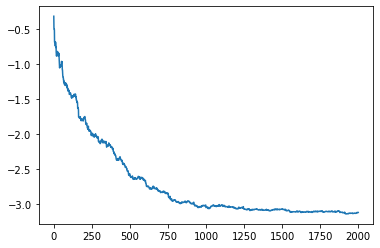

In [108]:
import matplotlib.pyplot as plt

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [109]:
import pickle

file_to_store = open("VQE_Gunlycke_2_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_alpha_"+str(alpha)+"_gamma_"+str(gamma)+".pickle", "wb")

pickle.dump(out, file_to_store)

In [110]:
import pickle

file_to_read = open("VQE_Gunlycke_2_T"+str(T)+"_A_"+str(A)+"_a_"+str(a)+"_c_"+str(c)+"_alpha_"+str(alpha)+"_gamma_"+str(gamma)+".pickle", "rb")

loaded_object = pickle.load(file_to_read)

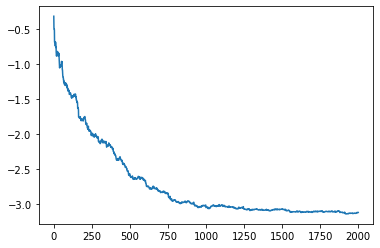

In [111]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [364]:
def SPSA_from_load(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    #alpha = 0.602
    alpha = 0.201
    A = 10
    a = 0.6
    gamma = 0.101
    c = 0.4
    phi_k = np.array(phi)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**alpha)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = loaded_object[k]['Delta']
        
            
        #Find E    
        E_A = find_E(phi_k + c_k*Delta_k, blocks, method = method)
        E_B = find_E(phi_k - c_k*Delta_k, blocks, method = method)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k

        
        #Calculate new E
        E_f = np.real(find_E(phi_k, blocks, method = method))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [365]:
El,psi_f = SPSA_from_load(500,method = 'simple',hold = False)

k= 0 c_k= 0.4 a_k= 0.37053677789517936 g= 0.31221237166560845 E_A= (0.6483890629959139+0j) E_B= (0.39861916566342714+0j) E_f= -0.2941674404659663
k= 1 c_k= 0.372954594574733 a_k= 0.36411269399518237 g= -0.26600035420340845 E_A= (0.2901614058922417+0j) E_B= (0.48857351440957686+0j) E_f= -0.2754518896460993
k= 2 c_k= 0.3579898757427053 a_k= 0.35830150846605 g= -0.23292677706300263 E_A= (0.29719469765243134+0j) E_B= (0.4639655536082976+0j) E_f= -0.2587121931480509
k= 3 c_k= 0.34773782403600867 a_k= 0.3530039095073033 g= 0.21234021146877308 E_A= (0.4327031217365752+0j) E_B= (0.28502567555358105+0j) E_f= -0.2459624290385531
k= 4 c_k= 0.33998833831625347 a_k= 0.3481423907099719 g= -0.8282619743549222 E_A= (0.03284742681671075+0j) E_B= (0.5960462515196494+0j) E_f= -0.08100027444187621
k= 5 c_k= 0.3337849224236992 a_k= 0.3436553693939271 g= -0.7447356728411818 E_A= (0.2115041071735653+0j) E_B= (0.7086671847444759+0j) E_f= 0.038152202417291815
k= 6 c_k= 0.32862839767254015 a_k= 0.33949315101716

k= 52 c_k= 0.267860162826851 a_k= 0.2609058398079971 g= -0.6637781002455034 E_A= (-1.0971474553042815+0j) E_B= (-0.7415480352789647+0j) E_f= -1.0994263698402225
k= 53 c_k= 0.26735494522142605 a_k= 0.26008126905440593 g= 1.407911354082114 E_A= (-0.5476712911724904+0j) E_B= (-1.3004954170669851+0j) E_f= -1.2750908604996083
k= 54 c_k= 0.2668599250350944 a_k= 0.2592720285936403 g= 0.3115613639478683 E_A= (-1.0104499459650993+0j) E_B= (-1.176736430419019+0j) E_f= -1.2814667599546898
k= 55 c_k= 0.26637471655715955 a_k= 0.25847760404433856 g= 0.1171148371603351 E_A= (-1.027592537004671+0j) E_B= (-1.0899854001111153+0j) E_f= -1.2818743830349033
k= 56 c_k= 0.2658989552298248 a_k= 0.2576975057492954 g= 0.5293579784046106 E_A= (-0.8792011062133299+0j) E_B= (-1.1607125730140462+0j) E_f= -1.282086350580811
k= 57 c_k= 0.26543229614067565 a_k= 0.2569312672388709 g= -0.139467602267511 E_A= (-1.0908689506251905+0j) E_B= (-1.0168305388109906+0j) E_f= -1.2801628270984842
k= 58 c_k= 0.26497441264651617 a_

k= 103 c_k= 0.25023014297472496 a_k= 0.23158657254318332 g= 0.16197514333165727 E_A= (-1.5241987206105965+0j) E_B= (-1.6052608471590608+0j) E_f= -1.7613944770531855
k= 104 c_k= 0.24998840873867942 a_k= 0.23118038596666274 g= -0.10559690922187386 E_A= (-1.610454788001996+0j) E_B= (-1.5576587813937979+0j) E_f= -1.76175682998874
k= 105 c_k= 0.24974919607452548 a_k= 0.2307784194017882 g= 0.23095575564585205 E_A= (-1.5114396716308858+0j) E_B= (-1.626801700233558+0j) E_f= -1.7663220086037088
k= 106 c_k= 0.2495124552599996 a_k= 0.23038059318858709 g= 0.35943278297641235 E_A= (-1.4573368947696406+0j) E_B= (-1.636702807132399+0j) E_f= -1.7735644700799984
k= 107 c_k= 0.24927813800651724 a_k= 0.22998682983541768 g= 0.3459481684476991 E_A= (-1.506252183827228+0j) E_B= (-1.6787268143820429+0j) E_f= -1.781116290224153
k= 108 c_k= 0.24904619740500722 a_k= 0.22959705394216187 g= -0.07873932143333032 E_A= (-1.6728575169562512+0j) E_B= (-1.6336380597778082+0j) E_f= -1.7823494830513171
k= 109 c_k= 0.2488

k= 153 c_k= 0.24050294487280224 a_k= 0.21526213181371276 g= 0.008744785336365263 E_A= (-1.7012406417363366+0j) E_B= (-1.7054469349876893+0j) E_f= -1.8713081976727461
k= 154 c_k= 0.24034577371294386 a_k= 0.2149992661706627 g= 0.22835649338188035 E_A= (-1.6435933200044097+0j) E_B= (-1.7533623561728953+0j) E_f= -1.8746302585197436
k= 155 c_k= 0.2401897150315199 a_k= 0.2147383069429348 g= -0.11426817501444562 E_A= (-1.7170791951622109+0j) E_B= (-1.6621871143744278+0j) E_f= -1.8751852786255994
k= 156 c_k= 0.24003475389827156 a_k= 0.21447922894421484 g= -0.28188096762304243 E_A= (-1.780900692284657+0j) E_B= (-1.6455782349006498+0j) E_f= -1.8829435060946635
k= 157 c_k= 0.23988087567680955 a_k= 0.21422200746922634 g= -0.1585448649172057 E_A= (-1.6936271332024946+0j) E_B= (-1.617563371141693+0j) E_f= -1.884116907322624
k= 158 c_k= 0.239728066017013 a_k= 0.21396661828174487 g= -0.16711155153215504 E_A= (-1.7323649605872646+0j) E_B= (-1.6522423024714528+0j) E_f= -1.8846123935717023
k= 159 c_k= 0.

k= 203 c_k= 0.23376922896323718 a_k= 0.20405069669827428 g= 0.13578834536009146 E_A= (-1.6945963510230346+0j) E_B= (-1.7580826246170793+0j) E_f= -1.9496523984210854
k= 204 c_k= 0.23365380153244633 a_k= 0.2038595775662753 g= -0.055417386332366134 E_A= (-1.7638914421314666+0j) E_B= (-1.7379944761563675+0j) E_f= -1.950437165964479
k= 205 c_k= 0.23353899237344763 a_k= 0.20366952306447533 g= -0.11792461007270193 E_A= (-1.795947970823381+0j) E_B= (-1.74086798159856+0j) E_f= -1.9518037972365203
k= 206 c_k= 0.23342479519724088 a_k= 0.20348052237451628 g= -0.09071368922306194 E_A= (-1.6991096595159274+0j) E_B= (-1.6567600108589686+0j) E_f= -1.9520031840421188
k= 207 c_k= 0.23331120380879006 a_k= 0.20329256483718383 g= 0.0483423105819938 E_A= (-1.7528395583647574+0j) E_B= (-1.7753971637183241+0j) E_f= -1.9525761027164394
k= 208 c_k= 0.2331982121051757 a_k= 0.20310563994934921 g= -0.0935832220514162 E_A= (-1.7761447814022004+0j) E_B= (-1.7324979012713366+0j) E_f= -1.9536927717094683
k= 209 c_k= 0

k= 253 c_k= 0.22865030548461726 a_k= 0.19561802104402623 g= 0.0493258290739389 E_A= (-1.7798753465321824+0j) E_B= (-1.8024320783042587+0j) E_f= -1.9759434919769092
k= 254 c_k= 0.22855958199258958 a_k= 0.19546942243156754 g= -0.057220595838998106 E_A= (-1.798263763672948+0j) E_B= (-1.7721071327402913+0j) E_f= -1.9763447043090334
k= 255 c_k= 0.22846924936970905 a_k= 0.19532149575799884 g= 0.05709263782042086 E_A= (-1.7882460155971356+0j) E_B= (-1.814333839811872+0j) E_f= -1.9766798247858155
k= 256 c_k= 0.22837930441497245 a_k= 0.19517423547591145 g= 0.031779577093912076 E_A= (-1.801824982732855+0j) E_B= (-1.8163405781554742+0j) E_f= -1.976889071770436
k= 257 c_k= 0.22828974396591784 a_k= 0.1950276361042541 g= 0.03729601650757049 E_A= (-1.791113483104523+0j) E_B= (-1.8081420792234468+0j) E_f= -1.9768232738242546
k= 258 c_k= 0.22820056489801344 a_k= 0.19488169222729543 g= 0.006766089520059693 E_A= (-1.820123037684761+0j) E_B= (-1.8232110885860173+0j) E_f= -1.9768788105756334
k= 259 c_k= 0.

k= 303 c_k= 0.2245379531555281 a_k= 0.1889158475879403 g= -0.019615701884670322 E_A= (-1.7602038357017515+0j) E_B= (-1.7513948965999657+0j) E_f= -1.98032834121638
k= 304 c_k= 0.22446348815402628 a_k= 0.18879514811017423 g= -0.015041963527366373 E_A= (-1.807511441626499+0j) E_B= (-1.8007586984224224+0j) E_f= -1.9804480317890927
k= 305 c_k= 0.22438929147512626 a_k= 0.1886749079481776 g= -0.005379159727201483 E_A= (-1.7702282511470542+0j) E_B= (-1.7678141994672176+0j) E_f= -1.9804321975331283
k= 306 c_k= 0.2243153612798253 a_k= 0.18855512390879003 g= -0.034871426066510405 E_A= (-1.7960331364346231+0j) E_B= (-1.7803887433617192+0j) E_f= -1.9805199722103088
k= 307 c_k= 0.2242416957476633 a_k= 0.18843579283103418 g= -0.032066339120264485 E_A= (-1.7986848505079438+0j) E_B= (-1.7843036299864483+0j) E_f= -1.980643996427383
k= 308 c_k= 0.22416829307647623 a_k= 0.1883169115856913 g= 0.016437240735645058 E_A= (-1.8042523980589036+0j) E_B= (-1.811621814456097+0j) E_f= -1.9806908605402178
k= 309 c_k

k= 353 c_k= 0.22111115942370668 a_k= 0.18338756003289805 g= 0.03882221520856018 E_A= (-1.7998008757955735+0j) E_B= (-1.8169689258278963+0j) E_f= -1.9820295317492296
k= 354 c_k= 0.2210481719458794 a_k= 0.18328646055073458 g= 0.0071509458131375405 E_A= (-1.8159274534849292+0j) E_B= (-1.8190888604842854+0j) E_f= -1.982010473015273
k= 355 c_k= 0.22098537951573047 a_k= 0.18318569318138667 g= -0.0019019534642685481 E_A= (-1.8242452398534958+0j) E_B= (-1.8234046320372506+0j) E_f= -1.9820130283647297
k= 356 c_k= 0.22092278098392504 a_k= 0.18308525593090869 g= -0.0038706887352812466 E_A= (-1.8230589603195704+0j) E_B= (-1.8213487136801274+0j) E_f= -1.981995495332018
k= 357 c_k= 0.2208603752110963 a_k= 0.1829851468227179 g= -0.02755966959595011 E_A= (-1.7940244271544605+0j) E_B= (-1.7818507492191498+0j) E_f= -1.9818850452459345
k= 358 c_k= 0.22079816106773162 a_k= 0.1828853638973968 g= -0.025775513851473135 E_A= (-1.7944604951253116+0j) E_B= (-1.7830781230073494+0j) E_f= -1.98201530577851
k= 359 

k= 403 c_k= 0.2181802692919501 a_k= 0.178703962236058 g= -0.010292584394149944 E_A= (-1.8269843762250224+0j) E_B= (-1.822493098555371+0j) E_f= -1.9821872263662588
k= 404 c_k= 0.2181257984204375 a_k= 0.17861732579176134 g= -0.01397943804524545 E_A= (-1.8192733892152475+0j) E_B= (-1.813174837045071+0j) E_f= -1.9821662925072885
k= 405 c_k= 0.2180714754281335 a_k= 0.17853093970918948 g= 0.004043741360277849 E_A= (-1.7976272361660897+0j) E_B= (-1.7993908854554608+0j) E_f= -1.9821446936108817
k= 406 c_k= 0.2180172995508166 a_k= 0.17844480266562 g= 0.005504211774597279 E_A= (-1.7852497522691575+0j) E_B= (-1.7876497790436645+0j) E_f= -1.982131343482575
k= 407 c_k= 0.21796327003008015 a_k= 0.17835891334846937 g= 0.0011722443329561072 E_A= (-1.801086633472+0j) E_B= (-1.8015976458881706+0j) E_f= -1.9821261851195617
k= 408 c_k= 0.2179093861132739 a_k= 0.1782732704551914 g= 0.00961478644325766 E_A= (-1.8063669744072754+0j) E_B= (-1.8105572788301965+0j) E_f= -1.982162633667444
k= 409 c_k= 0.21785564

k= 453 c_k= 0.2156241250645643 a_k= 0.17465504553076158 g= 0.009446685368866442 E_A= (-1.8186774143847995+0j) E_B= (-1.8227512809196436+0j) E_f= -1.9826608724809287
k= 454 c_k= 0.21557621389665993 a_k= 0.17457948453338862 g= 0.0191982866251469 E_A= (-1.8247353705263607+0j) E_B= (-1.8330127584142648+0j) E_f= -1.9827637711465338
k= 455 c_k= 0.21552841852324142 a_k= 0.17450411844306418 g= -0.011228681778111526 E_A= (-1.803329787273987+0j) E_B= (-1.7984895872225128+0j) E_f= -1.9827469403049183
k= 456 c_k= 0.21548073841143345 a_k= 0.17442894634039197 g= -0.00574623040761278 E_A= (-1.7894589045678506+0j) E_B= (-1.7869825006252213+0j) E_f= -1.9827223173735788
k= 457 c_k= 0.2154331730319722 a_k= 0.1743539673122692 g= -0.007685584631084743 E_A= (-1.8168967167008234+0j) E_B= (-1.8135852569334627+0j) E_f= -1.9826985403407287
k= 458 c_k= 0.21538572185917312 a_k= 0.1742791804518308 g= 0.0124803870127395 E_A= (-1.802406528289735+0j) E_B= (-1.8077827226213765+0j) E_f= -1.982694716952244
k= 459 c_k= 0

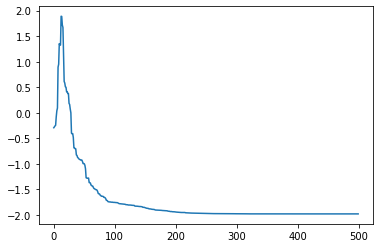

In [367]:
import matplotlib.pyplot as plt

tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [30]:
pwd

'C:\\Users\\jsten\\IBMQ\\Hubbard_symmetries'